# Basilico Nature Communication Paper
## Xiaonan Wang
## 02Feb2020

## Introduction

This is to reproduce the Figure2C used in the main content in Basilico Nature communication paper. The data was projected onto Wilson data published in Blood 2018 (PMID: 29588278) using on the PCA space.

In total, 157 cells were projected onto a landscape consisted of 44802 cells, of which:
1. Parental cells: 47
2. ME-Parental cells: 46
3. MLLENL-BM cells: 32
3. ME-preleukaemia cells: 32

The required files can be downloaded from ./Data/Projection_data.tar.gz.

In [2]:
#### Load required python packages
import numpy as np
import pandas as pd
import scanpy.api as sc

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)
sc.logging.print_versions()

scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==0.25.3 scikit-learn==0.22.1 statsmodels==0.11.0rc2 python-igraph==0.7.1 louvain==0.6.1


In [ ]:
def Obs_sublabels(ref_data, proj_data, proj_data_obs, cl_assigned, prefix):
    CT = np.unique(proj_data.obs[proj_data_obs])
    print(CT)
    for ct in CT:
        cl_assigned_sub = [cl_assigned[i] for i in np.where(proj_data.obs[proj_data_obs] == ct)[0]]
        cl_flat_sub = [item for sublist in cl_assigned_sub for item in sublist]
        freq1 = Counter(cl_flat_sub)
        freq2 = np.array([0] * ref_data.X.shape[0])
        for k, i in freq1.items():
            if k in ref_data.obs_names:
                idx = np.where(ref_data.obs_names==k)
                freq2[idx] = i
        ref_data.obs[prefix+'_'+ct] = np.log2(freq2+1)

## Projection

In [3]:
#### Read in Basilico data
Basilico_data = sc.read('./Projection_data/Projection_cnt.txt', cache=True)

... writing an h5ad cache file to speedup reading next time


In [6]:
#### Add in feature and metadata information to the scanpy object
GN = np.genfromtxt('./Projection_data/Projection_gtable.txt', delimiter='\t', dtype=str)
label = np.genfromtxt('./Projection_data/Projection_meta.txt', delimiter='\t', dtype=str)
Basilico_data.var_names = GN[:,1]
Basilico_data.var['ensembl'] = GN[:,0]
Basilico_data.obs['Condition'] = label[:,1]
Basilico_data.var_names_make_unique()
print(Basilico_data.X.shape)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(157, 46082)


In [9]:
#### filtering and normalisation
sc.pp.filter_cells(Basilico_data, min_genes=200)
sc.pp.filter_genes(Basilico_data, min_counts=1)
print(Basilico_data.X.shape)
sc.pp.normalize_per_cell(Basilico_data, counts_per_cell_after=10000)

(157, 27426)
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [11]:
#### Read in Wilson data
Wilson_data = sc.read('/servers/lila-single-cell/Xiaonan/Fernando_US_D1_TenX/Niki_10X_data/WT_10X_data/scanpy_filtered_all_genes_matrix_both.h5', cache=True)
Wilson_data.var_names_make_unique()
print(Wilson_data.X.shape)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(44802, 17633)


In [12]:
#### Add in feature and metadata information to the scanpy object
CellSubType = np.genfromtxt('/servers/lila-single-cell/Xiaonan/Fernando_US_D1_TenX/Niki_10X_data/WT_10X_data/xiaonan_coarse_clustering.txt', dtype=str)
CellSubType1 = CellSubType[np.append(range(21809,44802), range(0,21809))]
TypeMatch = ['Immature', 'Immature', 'Immature', 'HSCs', 'Early erythroid', 'MEP', 'Neutrophil', 'Late erythroid', 'Middle erythroid', 'Lymphoid', 'Middle erythroid', 'Megakryocyte', 'Basophil', 'Unknown', 'Unknown', 'Unknown']
TypeMatch_unique = np.unique(TypeMatch)
CellSubType_new = np.array(['Unknown']*Wilson_data.X.shape[0])
for i in range(16):
    CellSubType_new[CellSubType1==str(i)] = TypeMatch[i]
Wilson_data.obs['CellSubType'] = CellSubType_new

Wilson_hvg = np.genfromtxt('/servers/lila-single-cell/Xiaonan/Fernando_US_D1_TenX/Niki_10X_data/WT_10X_data/gene_names.txt', dtype=str)
print(len(Wilson_hvg))

Wilson_co = pd.read_csv('/servers/lila-single-cell/Xiaonan/Fernando_US_D1_TenX/Niki_10X_data/WT_10X_data/gephi_coorindates.txt')
Wilson_data.obsm['X_draw_graph_fa'] = np.array(Wilson_co[['X', 'Y']])
Wilson_data.uns['draw_graph'] = {}
Wilson_data.uns['draw_graph']['params'] = {'layout': 'fa', 'random_state': 0}

4666


In [13]:
#### Subset with overlapped highly variable genes
OLG = np.intersect1d(Wilson_hvg, Basilico_data.var_names)
print(len(OLG))

Basilico_data = Basilico_data[:,OLG]
Wilson_data = Wilson_data[:,OLG]
print(Basilico_data.shape)
print(Wilson_data.shape)

#### Renormalise the data for projection
sc.pp.normalize_per_cell(Basilico_data, counts_per_cell_after=10000)
sc.pp.normalize_per_cell(Wilson_data, counts_per_cell_after=10000)

sc.pp.log1p(Basilico_data)
sc.pp.log1p(Wilson_data)

4271
(157, 4271)
(44802, 4271)
normalizing by total count per cell


Trying to set attribute `.obs` of view, making a copy.


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
normalizing by total count per cell


Trying to set attribute `.obs` of view, making a copy.


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [14]:
#### Projection based on top 50 PCA components
from sklearn.decomposition import PCA
pca_ = PCA(n_components=50, svd_solver='auto', random_state=0)

In [17]:
pca_.fit(Wilson_data.X.toarray())

X_pca1 = pca_.transform(Wilson_data.X.toarray())
X_pca2 = pca_.transform(Basilico_data.X)
print(X_pca1.shape)
print(X_pca2.shape)

(44802, 50)
(157, 50)


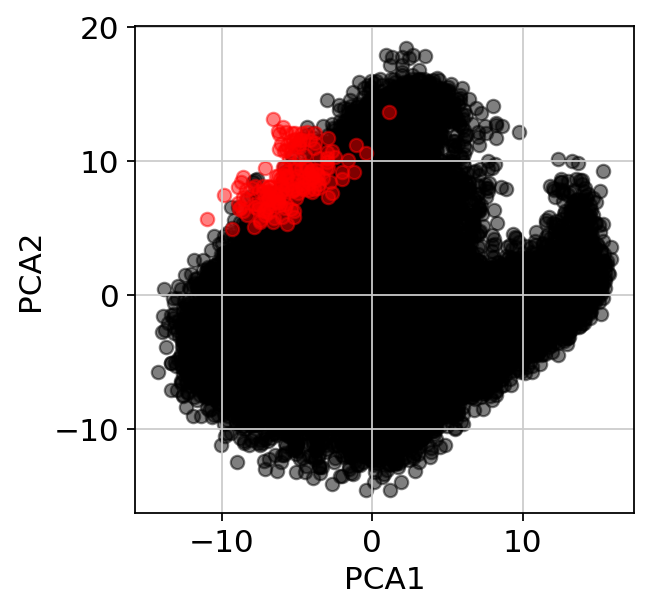

In [18]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(X_pca1[:,0], X_pca1[:,1], c='black', alpha=0.5)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
ax1.scatter(X_pca2[:,0], X_pca2[:,1], c='red', alpha=0.5)
plt.show()

In [19]:
#### Educlidean distance calculated based on the PCA space
X_pca = np.concatenate((X_pca1, X_pca2), axis=0)
print(X_pca.shape)

from sklearn.metrics.pairwise import euclidean_distances
D = euclidean_distances(X_pca, X_pca)

(44959, 50)


In [20]:
D_sub = D[44802:44959, 0:44802]

In [21]:
#### find the nearest 15 neighbours from Basilico data to Wilson data
from collections import Counter
cl_assigned = []
#minDis = []
for i in range(D_sub.shape[0]):
    CellDis = D_sub[i,:]
    CellDis_sorted = np.argpartition(CellDis, 15)[:15]
    max_samples = Wilson_data.obs_names[CellDis_sorted]
    cl_assigned.append(max_samples)

In [24]:
#### Create new observations in Wilson data according to the assignment of Basilico cells
Obs_sublabels(Wilson_data, Basilico_data, 'Condition', cl_assigned, 'SubType')

['ME-Parental' 'ME-Preleukaemia' 'MLLENL-BM' 'Parental']


In [25]:
keys2use = np.array([x for x in Wilson_data.obs_keys() if 'SubType' in x ])

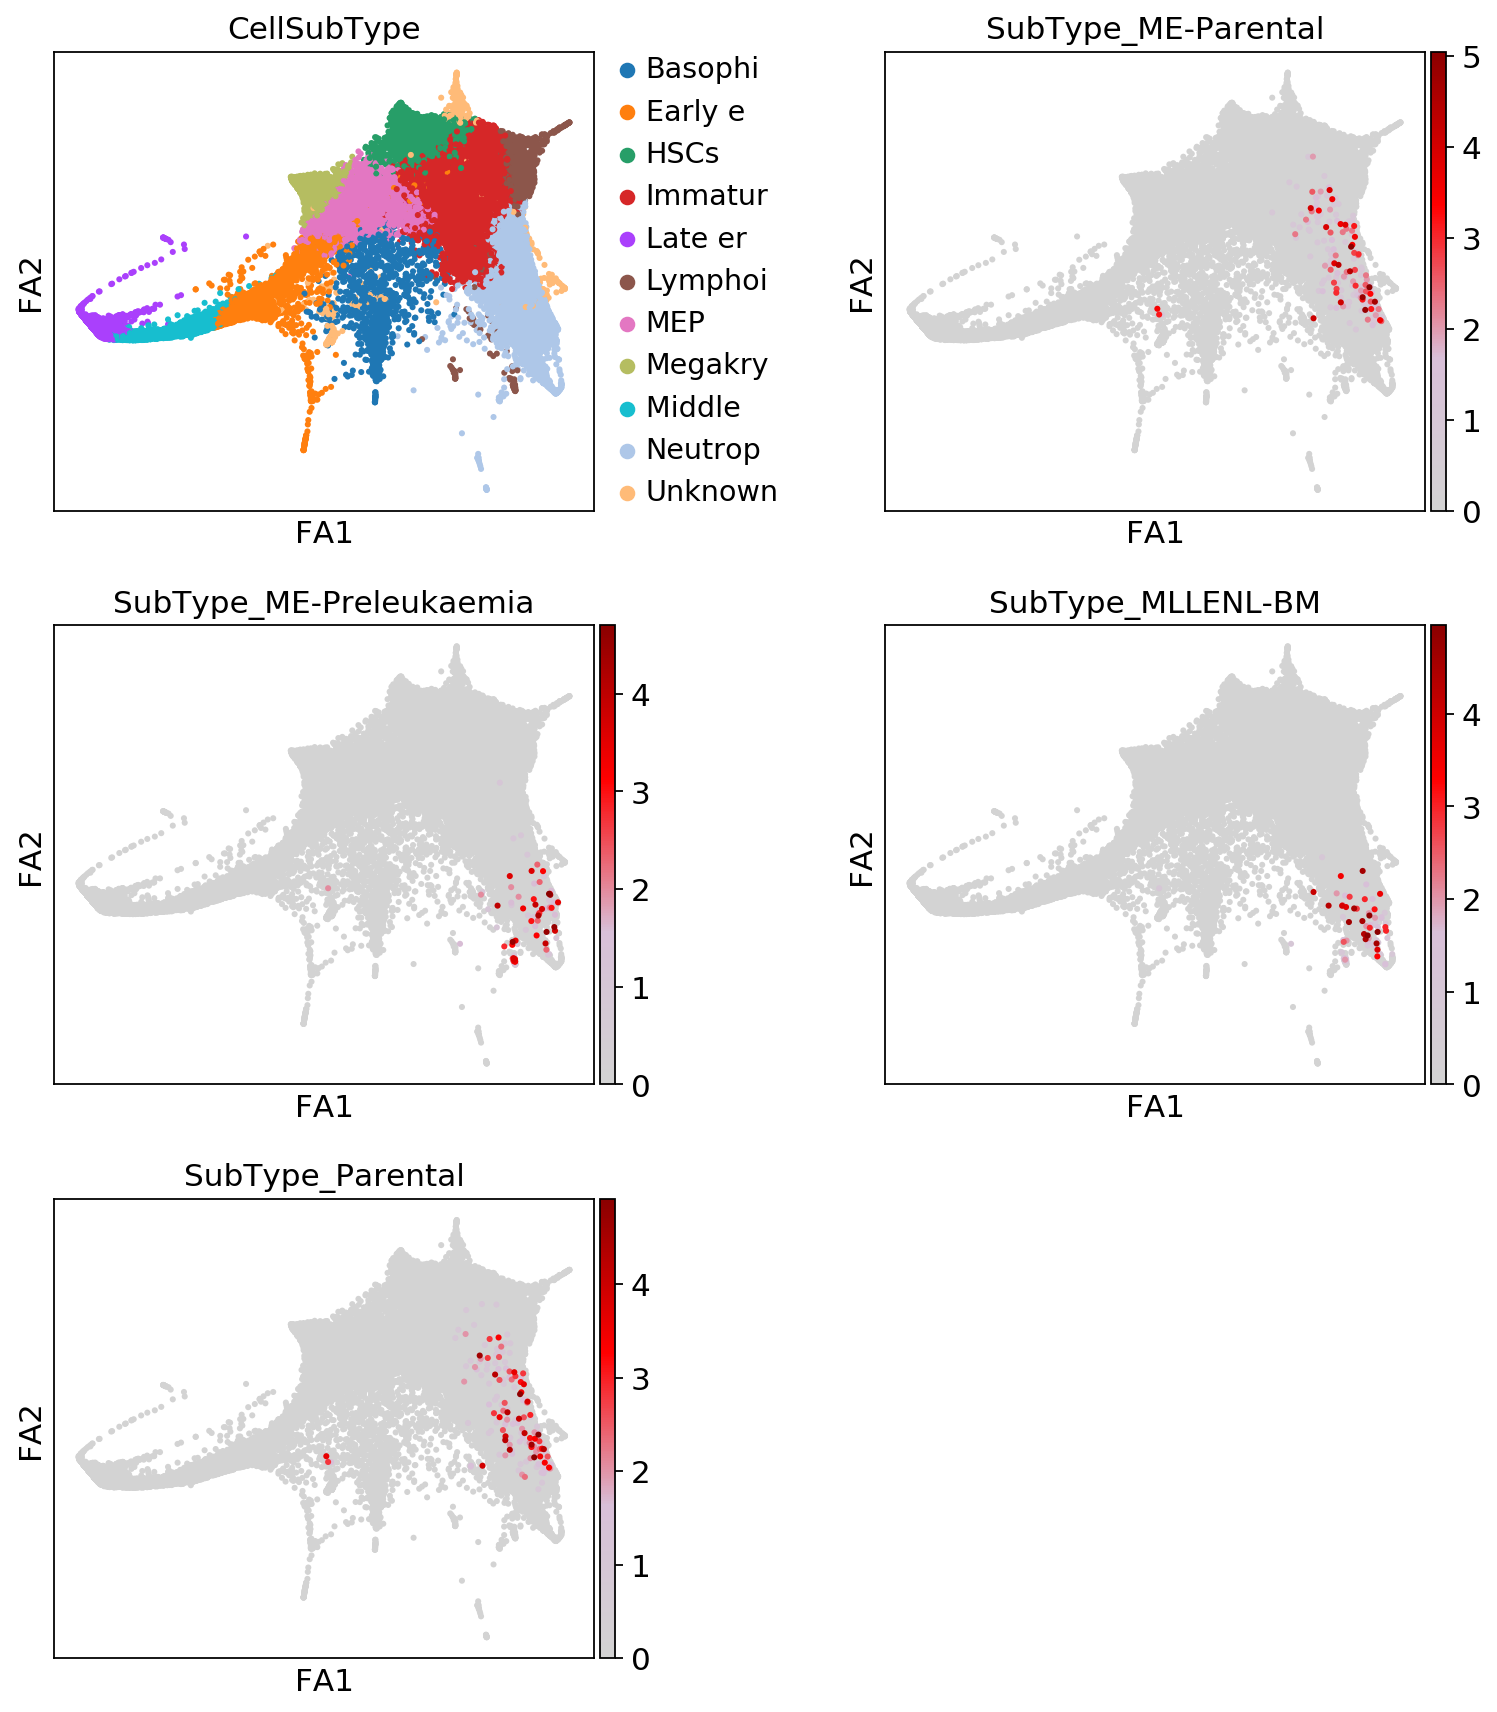

In [28]:
#### Plot out the assigned cells
sc.pl.draw_graph(Wilson_data, color=keys2use, ncols=2, wspace = 0.4, legend_loc="right margin", color_map=cmap, size=30)